In [1]:
import pandas as pd
import os

import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

ecb_with_sentiment = pd.read_csv('./ecb_with_sentiment_vader.csv')
ecb_with_sentiment.head()

ecb_with_sentiment=ecb_with_sentiment.drop(columns=["contents"])
# ecb_with_sentiment = ecb_with_sentiment.loc[ecb_with_sentiment.subtitle.str.contains("\sMember\s"),:]

In [3]:
ecb_with_sentiment.to_csv('./ecb_sentiment_only_vader.csv')

In [4]:
ecb_with_sentiment.head()

,Unnamed: 0,date,speakers,title,subtitle,mean,std,pos_mean,pos_std,neu_mean,neu_std,neg_mean,neg_std,pos_np,neu_np,neg_np
0,0,2021-05-27,Isabel Schnabel,Societal responsibility and central bank indep...,"Keynote speech by Isabel Schnabel, Member of t...",0.010427,0.458839,0.081060,0.116305,0.848940,0.151513,0.070013,0.100979,[0. 0.117 0.154 0.278 0.213 0.278 0. 0.1...,[1. 0.742 0.846 0.722 0.787 0.722 0.854 0.7...,[0. 0.141 0. 0. 0. 0. 0.146 0.1...
1,1,2021-05-27,Luis de Guindos,Climate change and financial integration,"Keynote speech by Luis de Guindos, Vice-Presid...",0.023541,0.534771,0.126548,0.126126,0.763849,0.168757,0.109624,0.138958,[0.078 0.105 0. 0.147 0.317 0.064 0.169 0. ...,[0.922 0.349 0.565 0.706 0.683 0.936 0.574 0.7...,[0. 0.547 0.435 0.147 0. 0. 0.257 0.2...
2,3,2021-05-19,Fabio Panetta,At the edge of tomorrow: preparing the future ...,"Introductory remarks by Fabio Panetta, Member ...",0.263880,0.291748,0.099200,0.108759,0.895800,0.106926,0.005000,0.024428,[0.07 0.107 0.146 0.264 0. 0.14 0. 0. ...,[0.93 0.893 0.854 0.736 1. 0.86 0.851 1. ...,[0. 0. 0. 0. 0. 0. 0.149 0. ...
3,4,2021-05-06,Christine Lagarde,Towards a green capital markets union for Europe,"Speech by Christine Lagarde, President of the ...",0.241703,0.407881,0.125387,0.119996,0.833194,0.146953,0.041452,0.078642,[0.115 0. 0. 0.247 0.078 0. 0. 0.1...,[0.885 1. 1. 0.753 0.922 1. 1. 0.8...,[0. 0. 0. 0. 0. 0. 0. 0. ...
4,6,2021-04-29,Frank Elderson,All the way to zero: guiding banks towards a c...,"Keynote speech by Frank Elderson, Vice-Chair o...",-0.000324,0.495016,0.092496,0.113369,0.818575,0.128319,0.088921,0.096290,[0.09 0.144 0.495 0.294 0. 0. 0. 0.2...,[0.91 0.856 0.505 0.706 1. 1. 0.545 0.5...,[0. 0. 0. 0. 0. 0. 0.455 0.1...


1388
0.4


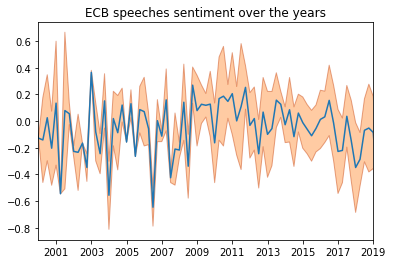

1284
0.41111111111111115


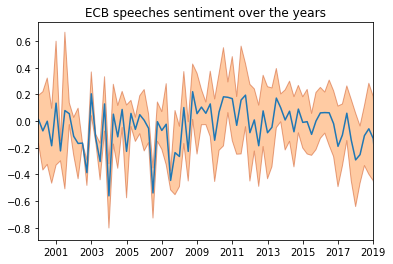

1201
0.4222222222222222


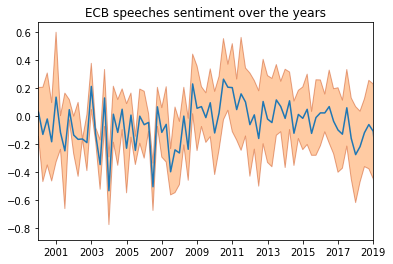

1109
0.43333333333333335


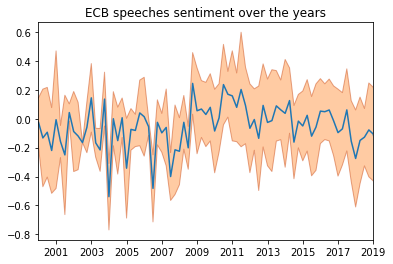

972
0.4444444444444445


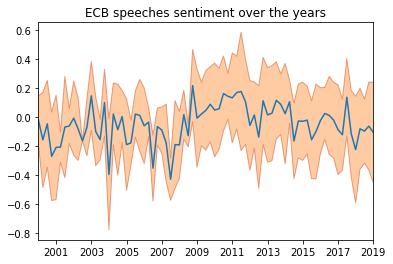

895
0.45555555555555555


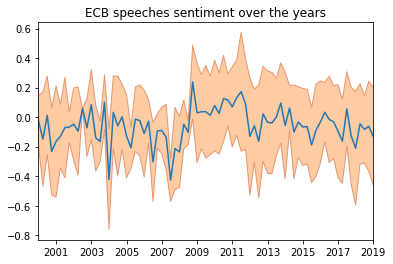

844
0.4666666666666667


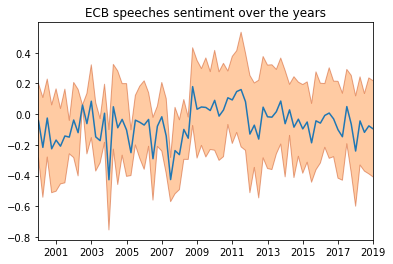

784
0.47777777777777775


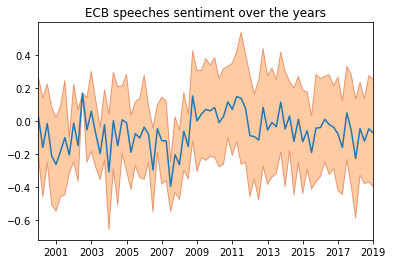

739
0.4888888888888889


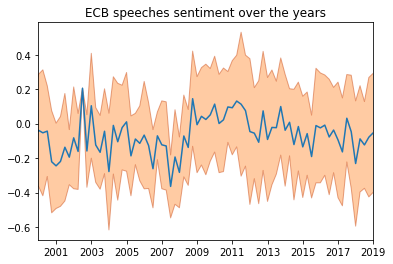

689
0.5


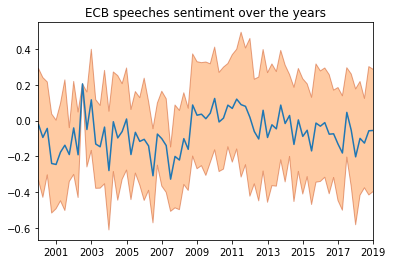

In [5]:
# threshold_neutral = 0.6
threshold_significance = 0.05

threshold_mean_significance = 0.05

for threshold_neutral in np.linspace(0.2,0.9,30):
    def remove_neutral(pos, neu, neg):
        pos = np.fromstring(pos[1:-1],sep=' ')
        neu = np.fromstring(neu[1:-1],sep=' ')
        neg = np.fromstring(neg[1:-1],sep=' ')
        combined = np.array([pos,neu,neg]).T #(num_of_sent,3)
        filtered = combined[neu<threshold_neutral]
        res = (filtered.T[0]-filtered.T[2]) 
        res = res[np.abs(res)>threshold_significance]
        return res


    ecb_with_sentiment['filtered'] = ecb_with_sentiment.apply(lambda row: remove_neutral(row['pos_np'],row['neu_np'],row['neg_np']),axis=1)

    ecb_with_sentiment['filtered_mean'] = ecb_with_sentiment.apply(lambda row: row['filtered'].mean(),axis=1)

    ecb_with_sentiment['filtered_std'] = ecb_with_sentiment.apply(lambda row: row['filtered'].std(),axis=1)


    old = len(ecb_with_sentiment)
    ecb_with_sentiment_new = ecb_with_sentiment[np.abs(ecb_with_sentiment.filtered_mean) > threshold_mean_significance]
    new = len(ecb_with_sentiment_new)
    print(old-new)

    # for each time interval (quarterly)
    #    check speech overal sentiment
    #    plot graph
    
    # quarters = ["({0})".format(i) for i in range(1,13)]
    quarters = ["(1|2|3)","(4|5|6)", "(7|8|9)","(10|11|12)"]
    # quarters = ["(1|2|3|4|5|6|7|8|9|10|11|12)"]
    # quarters = ["(1|2|3|4|5|6)","(7|8|9|10|11|12)"]

    col = ["year","quarter","mean","std",] # "fss_mean", "fss_std", "pos_mean", "pos_std", "neg_mean","neg_std"])

    quarterly_data = pd.DataFrame(columns = col) 


    for year in range(1997,2022):
        for index, quarter in enumerate(quarters):
            data = ecb_with_sentiment_new.loc[ecb_with_sentiment['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]
            # assume sample mean (neglect difference in datapoints)
            temp_data = pd.DataFrame([[year, index + 1, data['filtered_mean'].mean(), (data['filtered_std']**2).mean()**0.5]],columns = col)
        
            quarterly_data = quarterly_data.append(temp_data, ignore_index = True)

    quarterly_data.to_csv('./ecb_sentiment_quarterly_vader.csv')


    year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
    year = [item for sublist in year for item in sublist]
    # year = [ year for year in range(1997,2022)]
    mean = quarterly_data['mean'].to_numpy()
    std = quarterly_data['std'].to_numpy()
    # fss_mean = quarterly_data['fss_mean'].to_numpy()
    # fss_std = quarterly_data['fss_std'].to_numpy()
    # pos_mean = quarterly_data['pos_mean'].to_numpy()
    # pos_std = quarterly_data['pos_std'].to_numpy()
    # neg_mean = quarterly_data['neg_mean'].to_numpy()
    # neg_std = quarterly_data['neg_std'].to_numpy()

    fig = plt.figure()


    # import scipy.signal as signal

    # sos = signal.butter(536, 35, 'lp', fs=1000, output='sos')
    # filtered = signal.sosfiltfilt(sos, mean)

    x = year
    y = mean *-1
    yerr = std
    
    # plt.errorbar(x, y, yerr = yerr)
    plt.plot(x,y)

    plt.fill_between(x, y-yerr, y+yerr,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    
    plt.xticks(np.arange(1997, 2021, 2))
    plt.xlim(2000,2019)
    plt.title('ECB speeches sentiment over the years')
    print(threshold_neutral)
    plt.pause(0.5)
plt.show()
